In [40]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import pickle
import matplotlib
import ipyparams

path = os.getcwd().split(os.sep + 'GUI')[0]
if path not in sys.path:
    print("not here")
    sys.path.append(path)

from neurolib_dev_optControl.neurolib.models.aln import ALNModel
from neurolib_dev_optControl.neurolib.utils import plotFunctions as plotFunc
from neurolib_dev_optControl.neurolib.utils import func_optimize as fo
from neurolib_dev_optControl.neurolib.utils import costFunctions as cost
import neurolib_dev_optControl.neurolib.dashboard.functions as functions
import neurolib_dev_optControl.neurolib.dashboard.data as data
import neurolib_dev_optControl.neurolib.dashboard.layout as layout
    
# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2 

#path = os.path.join(os.getcwd(), "plots")

cmap_ = layout.getcolormap()
darkgrey, midgrey, lightgrey, color_bi_updown, color_LC, color_bi_uposc = layout.getcolors_rgba()
exc_red = cmap_(3)
inh_blue=cmap_(0)
green = cmap_(2)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
aln = ALNModel()
N = aln.params.N

data.set_parameters(aln)

state_vars = aln.state_vars
init_vars = aln.init_vars

##############################################################
def setinit(init_vars_, model):
    state_vars = model.state_vars
    init_vars = model.init_vars
    for iv in range(len(init_vars)):
        for sv in range(len(state_vars)):
            if state_vars[sv] in init_vars[iv]:
                #print("set init vars ", )
                if model.params[init_vars[iv]].ndim == 2:
                    model.params[init_vars[iv]][0,:] = init_vars_[sv]
                else:
                    model.params[init_vars[iv]][0] = init_vars_[sv]
                    
##############################################################               
def setmaxmincontrol(max_c_c, min_c_c, max_c_r, min_c_r):
    import numpy as np
    
    max_cntrl = np.zeros(( 6 ))
    min_cntrl = np.zeros(( 6 ))
    
    max_cntrl[0] = max_c_c
    min_cntrl[0] = min_c_c
    max_cntrl[1] = max_c_c
    min_cntrl[1] = min_c_c
    max_cntrl[2] = max_c_r
    min_cntrl[2] = min_c_r
    max_cntrl[3] = max_c_r
    min_cntrl[3] = min_c_r
    max_cntrl[4] = max_c_r
    min_cntrl[4] = min_c_r
    max_cntrl[5] = max_c_r
    min_cntrl[5] = min_c_r
            
    return max_cntrl, min_cntrl

In [43]:
savepath = (os.getcwd().split('neurolib')[0] + 'Talks_Conf_Workshops_Schools' + os.sep + '22' + os.sep + 'FRANCE22' + 
     os.sep + 'ENCODS' + os.sep + 'poster' + os.sep + 'images')

exc = 0.5
inh = 0.5

In [45]:
dur_pre = 10
dur_post = 10
dur = 200.
dt = aln.params.dt
T = int(1 + dur / dt)

max_it = 10
init_it = 10
prec_vars = [0,1]
trans_time = 0.8
repeat = 20

n_pre = int(np.around(dur_pre/aln.params.dt + 1.,1))
n_post = int(np.around(dur_post/aln.params.dt + 1.,1))

tol = 1e-32
start_step = 10.
c_scheme = np.zeros(( 1,1 ))
c_scheme[0,0] = 1.
u_mat = np.identity(1)
u_scheme = np.array([[1.]])

maxC = [5., -5., 0.18, 0.]
n_dur = int(np.around(dur/aln.params.dt + 1.,1))
max_cntrl, min_cntrl = setmaxmincontrol(maxC[0], maxC[1], maxC[2], maxC[3])

nb = ipyparams.notebook_name
print('nb = ', nb)

case = str(nb[4])

nb =  DU_M4.ipynb


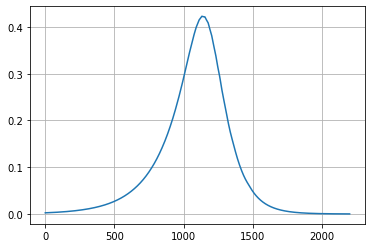

In [60]:
i = 28
t_range=[1500,3701]

noisefree_file = '..' + os.sep + '..' + os.sep + 'data_final_2' + os.sep + 'control_1.pickle'
file = open(noisefree_file, "rb")
noisefree = pickle.load(file)
file.close()
    
c_noisefree = noisefree[0][i][:,:,t_range[0]:t_range[1]]
plt.plot(c_noisefree[0,0,:])
plt.show()

In [48]:
sigma_ou_array = [0.01, 0.05]
noise_realizations_array = [0,20,50]
noise_realizations_final = 10000

In [49]:
n_sig = len(sigma_ou_array)
n_noise = len(noise_realizations_array)

int_t_pen = np.around( (1. - trans_time)*dur/aln.params.dt, 1).astype(int)

cost_final_mean = np.zeros(( n_sig,n_noise ))
target = [None] * n_sig
control_ = [ [None] * n_noise, [None] * n_noise ]
cost_ = control_.copy()
cost_final = control_.copy()

stable_state = np.zeros(( n_noise, 2,2,2, 2))

In [50]:
cost_final_mean = np.zeros(( n_sig,n_noise ))

In [52]:
# get init vars without noise
aln = ALNModel()
data.set_parameters(aln)
aln.params.duration = 3000.

# initial without noise
control0 = aln.getZeroControl()
control0[0,0,:500] = -5.

aln.params.ext_exc_current = exc * 5.
aln.params.ext_inh_current = inh * 5.

aln.run(control=control0)

init_state_vars = np.zeros(( len(state_vars) ))
for j in range(len(state_vars)):
    if aln.state[state_vars[j]].size == 1:
        init_state_vars[j] = aln.state[state_vars[j]][0]
    else:
        init_state_vars[j] = aln.state[state_vars[j]][0,-1]

initVars = init_state_vars

In [53]:
for i_sigma in range(len(sigma_ou_array)):
    
    sigma_ou = sigma_ou_array[i_sigma]
    aln.params.sigma_ou = sigma_ou
    

    aln.params.duration = dur
    control0 = aln.getZeroControl()
    control0[0,0,:500] = 5.

    target_rates_e = []
    target_rates_i = []

    stateswitchcount = 0

    for j in range(noise_realizations_final):
        aln.params.duration = dur
        aln.run(control=control0)
        if np.amin(aln.rates_exc[0,1000:]) < 1.:
            print("fell in down state, repeat")
            j -= 1
            stateswitchcount += 1
            if stateswitchcount > 0.1 * noise_realizations_final:
                break
            continue
        target_rates_e.append(aln.rates_exc[0,1000:])
        target_rates_i.append(aln.rates_inh[0,1000:])

    aln.params.duration = dur
    target[i_sigma] = aln.getZeroTarget()
    target[i_sigma][:,0,:] = np.mean(target_rates_e)
    target[i_sigma][:,1,:] = np.mean(target_rates_i)

    stable_state[i_sigma,1,1,0,0] = target[i_sigma][0,0,-1]
    stable_state[i_sigma,1,1,1,0] = target[i_sigma][0,1,-1]
    stable_state[i_sigma,1,1,0,1] = np.std(target_rates_e)
    stable_state[i_sigma,1,1,1,1] = np.std(target_rates_i)


    aln.params.duration = 300.
    control0 = aln.getZeroControl()
    control0[0,0,:500] = -5.

    target_rates_e = []
    target_rates_i = []

    stateswitchcount = 0

    for j in range(noise_realizations_final):
        aln.params.duration = 300.
        aln.run(control=control0)
        if np.amin(aln.rates_exc[0,1000:]) > 3.:
            print("fell in up state, repeat")
            j -= 1
            stateswitchcount += 1
            if stateswitchcount > 0.1 * noise_realizations_final:
                break
            continue
        target_rates_e.append(aln.rates_exc[0,1000:])
        target_rates_i.append(aln.rates_inh[0,1000:])

    stable_state[i_sigma,1,0,0,0] = np.mean(target_rates_e)
    stable_state[i_sigma,1,0,1,0] = np.mean(target_rates_i)
    stable_state[i_sigma,1,0,0,1] = np.std(target_rates_e)
    stable_state[i_sigma,1,0,1,1] = np.std(target_rates_i)

In [54]:
w_p = np.zeros((2))
for i_sigma in range(len(sigma_ou_array)):
    w_p[i_sigma] = 1. / ( ( stable_state[i_sigma,1,1,0,1] + stable_state[i_sigma,1,1,1,1] ) * (1. - trans_time) * dur )
w_e = 0.
w_s = 1.

aln.params.duration = dur
zero_init = aln.getZeroControl()

In [68]:
max_it = 15
init_it = 3
factor = [1.1, 1.5]

for i_sigma in range(len(sigma_ou_array)):
    
    cost.setParams(w_p[i_sigma], w_e, w_s)
    
    for i_noise in range(len(noise_realizations_array)):
        
        if i_sigma in [0]:
            continue
        if i_noise in []:
            continue

        noise_realizations = noise_realizations_array[i_noise]
        sigma_ou = sigma_ou_array[i_sigma]
        aln.params.sigma_ou = sigma_ou
        
        aln.params.duration = dur
        print(noise_realizations)
        
        if i_noise != 0.:

            setinit(initVars, aln)

            bestControl, bestState, c_, runtime, grad, phi, costnode, total_cost_mean_std = aln.A1(
                zero_init, target[i_sigma], c_scheme, u_mat, u_scheme, max_iteration_ = init_it,
                tolerance_ = tol, startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl,
                t_sim_ = dur, t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = None,
                control_variables_ = [0], prec_variables_ = prec_vars, transition_time_ = trans_time,
                noise_real=noise_realizations, init_params = initVars, method='M4')

            control_init = bestControl[:,:,100:-100].copy()
            setinit(initVars, aln)
            aln.params.duration = dur

            bestControl, bestState, c_, runtime, grad, phi, costnode, total_cost_mean_std = aln.A1(
                control_init, target[i_sigma], c_scheme, u_mat, u_scheme, max_iteration_ = max_it-init_it,
                tolerance_ = tol, startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl,
                t_sim_ = dur, t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = None,
                control_variables_ = [0,1], prec_variables_ = prec_vars, transition_time_ = trans_time,
                noise_real=noise_realizations, init_params = initVars,method='M4')


            control_[i_sigma][i_noise] = bestControl.copy()
        
        else:
            control_[i_sigma][i_noise] = factor[i_sigma] * c_noisefree[:,:,:]
        
        aln.params.duration = dur
        setinit(initVars, aln)

        init_control = aln.getZeroControl()   
        
        init_control[:,:,:] = control_[i_sigma][i_noise][:,:,100:-100]
            
        T = int(1 + dur/aln.params.dt)
        dt = aln.params.dt

        target_ = target[i_sigma].copy()
        target_[0,0,:int(trans_time * dur / aln.params.dt)] = -1000
        target_[0,1,:int(trans_time * dur / aln.params.dt)] = -1000

        cost_final = 0.
        cs = cost.numba_cost_sparsity_int(1, 6, T, w_s, dt, init_control)

        for n_ in range(noise_realizations_final):
            state_ = fo.updateState(aln, init_control)
            cost_final += cost.numba_cost_precision_int(1,T,dt,w_p[i_sigma],state_, target_, list(prec_vars) )

        cost_final_mean[i_sigma, i_noise] = cs + cost_final / noise_realizations_final
        print('mean = ', cost_final_mean[i_sigma, i_noise])

set cost params:  0.026379787824684704 0.0 1.0 0.0
set cost params:  0.00527123745542333 0.0 1.0 0.0
0
mean =  4.631408385047672
20
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  739.1634273739731
Gradient descend method:  None
RUN  1 , total integrated cost =  34.90114672116672
RUN  2 , total integrated cost =  24.982491547761818
RUN  3 , total integrated cost =  13.505411576550822
RUN  3 , total integrated cost mean =  13.505411576550822
Improved over  3  iterations in  1.429954961000476  seconds by  98.17287881456318  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13.296409562924424
Gradient descend method:  None
step size too small or too large
RUN  1 , total integrated cost =  7.857000929746837
RUN  2 , total integrated cost =  7.373293706165671
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  3 , total integrated cost =  6.941331188530

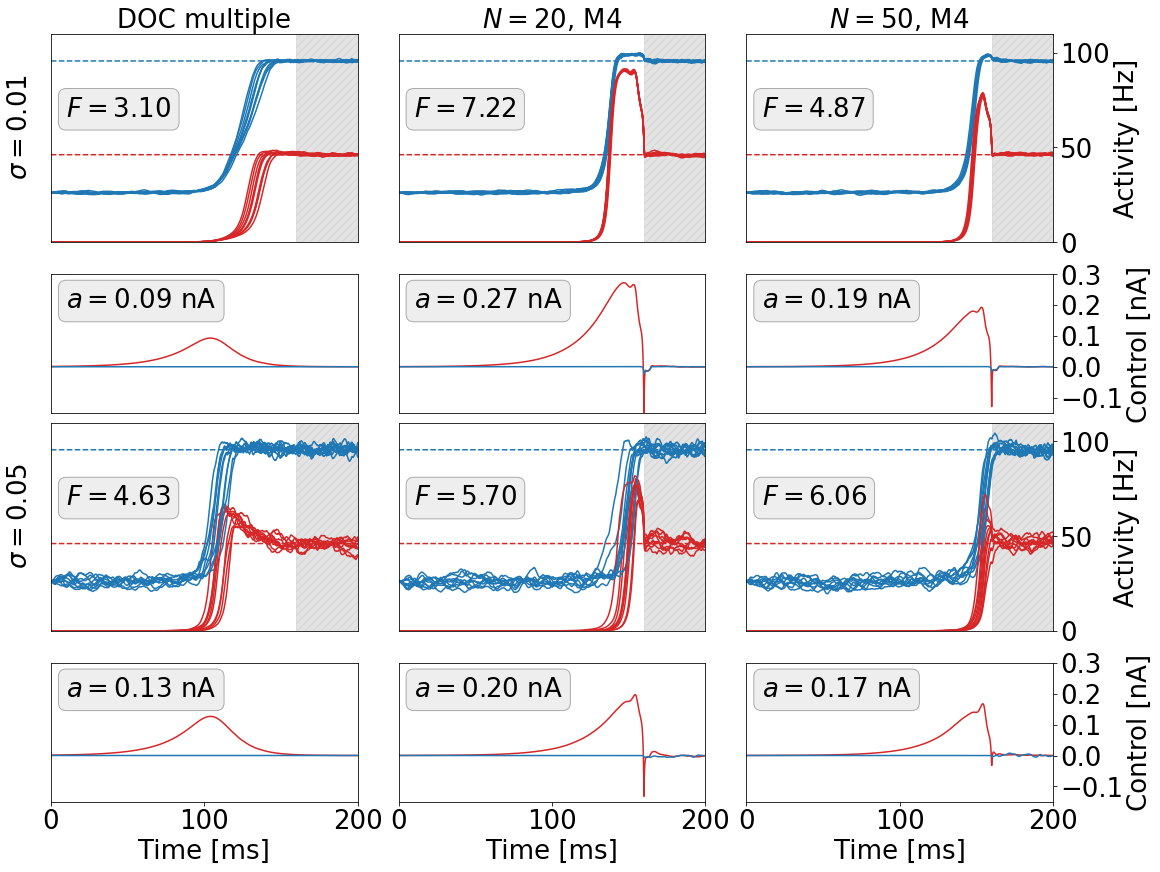

In [69]:
fs_ = 26
fig, ax = plt.subplots(4, 3, figsize=(16,12), constrained_layout=True, facecolor='white',
                       gridspec_kw={'height_ratios': [3,2,3,2]})
#fig.suptitle('Point b', fontsize=fs_)
plot_realizations = 10
i = 50

t_array = np.arange(0,dur+aln.params.dt,aln.params.dt)
ax[0,0].set_title('DOC multiple', fontsize=fs_)

setinit(initVars, aln)
aln.params.duration = dur
target_ = aln.getZeroTarget()

for i_sigma in range(2):
    
    target_[0,0,:] = target[i_sigma][0,0,-1]
    target_[0,1,:] = target[i_sigma][0,1,-1]
    
    for i_noise in range(3):
        
        noise_realizations = noise_realizations_array[i_noise]
        sigma_ou = sigma_ou_array[i_sigma]
        aln.params.sigma_ou = sigma_ou
        
        if i_noise != 0:
            ax[0,i_noise].set_title(r'$N=$' + '{}'.format(noise_realizations) + ', M4', fontsize=fs_)

        ax[2*i_sigma+1,i_noise].plot( t_array, control_[i_sigma][i_noise][0,0,100:-100]/5., color=exc_red)
        ax[2*i_sigma+1,i_noise].plot( t_array, control_[i_sigma][i_noise][0,1,100:-100]/5., color=inh_blue)
        
        ax[2*i_sigma,i_noise].plot( t_array, target_[0,0,:], linestyle='--', color=exc_red)
        ax[2*i_sigma,i_noise].plot( t_array, target_[0,1,:], linestyle='--', color=inh_blue)

        for indexx in range(plot_realizations):
            aln.run(control=control_[i_sigma][i_noise][:,:,100:-100])
            ax[2*i_sigma,i_noise].plot( t_array, aln.rates_exc[0,:], color=exc_red)
            ax[2*i_sigma,i_noise].plot( t_array, aln.rates_inh[0,:], color=inh_blue)

        ax[2*i_sigma,i_noise].text(0.05, 0.7, r'$F = $' + '{:.2f}'.format(cost_final_mean[i_sigma, i_noise]),
                horizontalalignment='left', verticalalignment='top', transform=ax[2*i_sigma,i_noise].transAxes,
                bbox=dict(boxstyle='round', facecolor=midgrey, alpha=0.3), fontsize=fs_)
        
        ax[2*i_sigma+1,i_noise].text(0.05, 0.9, r'$a = $' + '{:.2f} nA'.format(
            max( np.amax(np.abs(control_[i_sigma][i_noise][0,0,100:-100]/5.)),
               np.amax(np.abs(control_[i_sigma][i_noise][0,1,100:-100]/5.))) ),
            horizontalalignment='left', verticalalignment='top', transform=ax[2*i_sigma+1,i_noise].transAxes,
            bbox=dict(boxstyle='round', facecolor=midgrey, alpha=0.3), fontsize=fs_)

for j in range(4):
    for k in range(3):
        ax[j,k].tick_params(axis='x', labelsize=fs_)
        ax[j,k].tick_params(axis='y', labelsize=fs_)
        ax[j,k].set_xlim(0,dur)
        ax[j,k].grid(False)
        if j != 3:
            ax[j,k].set_xticks([])
        else:
            ax[j,k].set_xlabel('Time [ms]', fontsize=fs_)
        ax[j,k].set_yticks([])
        if j%2 == 0:
            ax[j,k].set_ylim(0,110)
            sigma_ou = sigma_ou_array[int(j/2)]
            ax[j,k].axvspan( dur*trans_time, dur, facecolor=midgrey,
                            alpha=0.5, zorder=-1, hatch='///', edgecolor = midgrey)
        elif j%2 == 1:
            ax[j,k].set_ylim(-0.15,0.3)
            
    if j%2 == 0:
        ax[j,-1].set_yticks(np.arange(0,110,50))
        ax[j,-1].set_ylabel('Activity [Hz]', fontsize=fs_)
        ax[j,-1].yaxis.set_label_position("right")
        ax[j,-1].yaxis.tick_right()
        ax[j,0].text(-0.1,0.3, r'$\sigma=$'+'{:.2f}'.format(sigma_ou_array[int(j/2)]), rotation=90, size=fs_,
                 verticalalignment='bottom', horizontalalignment='center', transform=ax[j,0].transAxes)
    
    elif j%2 == 1:     
        ax[j,-1].set_yticks(np.arange(-0.1,0.31,0.1))
        ax[j,-1].set_ylabel('Control [nA]', fontsize=fs_)
        ax[j,-1].yaxis.set_label_position("right")
        ax[j,-1].yaxis.tick_right()

filename_ = nb[:-6] + '.png'
    
fig.savefig(filename_)
fig.savefig(os.path.join(savepath, filename_))
plt.show()

In [71]:
n_noise = 3
control_1 = [ [None] * n_noise, [None] * n_noise, [None] * n_noise ]

In [76]:
for i_sigma in range(len(sigma_ou_array)):
    
    cost.setParams(w_p[i_sigma], w_e, w_s)
    
    for i_noise in [2]:
        
        if i_sigma in [0]:
            continue

        noise_realizations = noise_realizations_array[i_noise]
        sigma_ou = sigma_ou_array[i_sigma]
        aln.params.sigma_ou = sigma_ou
        
        aln.params.duration = dur
        zero_init = aln.getZeroControl()
        print(noise_realizations)

        setinit(initVars, aln)

        bestControl, bestState, c_, runtime, grad, phi, costnode, total_cost_mean_std = aln.A1(
            zero_init, target[i_sigma], c_scheme, u_mat, u_scheme, max_iteration_ = init_it,
            tolerance_ = tol, startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl,
            t_sim_ = dur, t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = None,
            control_variables_ = [0], prec_variables_ = prec_vars, transition_time_ = trans_time,
            noise_real=noise_realizations, init_params = initVars, method='M4')

        control_init = bestControl[:,:,100:-100].copy()
        setinit(initVars, aln)
        aln.params.duration = dur

        bestControl, bestState, c_, runtime, grad, phi, costnode, total_cost_mean_std = aln.A1(
            control_init, target[i_sigma], c_scheme, u_mat, u_scheme, max_iteration_ = max_it-init_it,
            tolerance_ = tol, startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl,
            t_sim_ = dur, t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = None,
            control_variables_ = [0,1], prec_variables_ = prec_vars, transition_time_ = trans_time,
            noise_real=noise_realizations, init_params = initVars,method='M4')

        control_1[i_sigma][i_noise] = bestControl.copy()

set cost params:  0.026379787824684704 0.0 1.0 0.0
set cost params:  0.00527123745542333 0.0 1.0 0.0
50
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  732.9240250770364
Gradient descend method:  None
RUN  1 , total integrated cost =  29.095905360171482
RUN  2 , total integrated cost =  14.763520636852542
step size too small or too large
RUN  3 , total integrated cost =  8.156588482168763
RUN  3 , total integrated cost mean =  8.156588482168763
Improved over  3  iterations in  1.824156311005936  seconds by  98.88711678112729  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7.697292136135264
Gradient descend method:  None
RUN  1 , total integrated cost =  7.750871731967196
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  2 , total integrated cost =  6.497979895589439
RUN  3 , total integrated cost =  6.415089569793784
step size too small or too

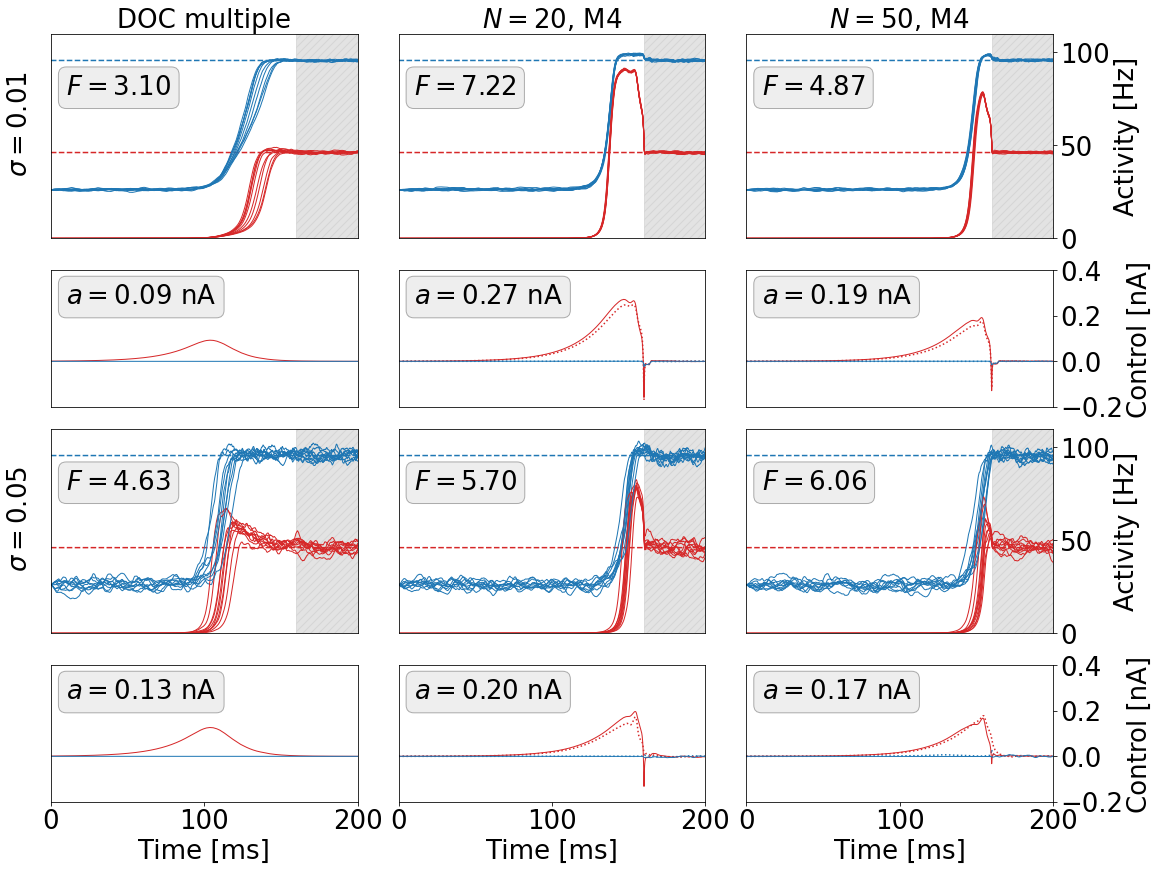

In [78]:
fig, ax = plt.subplots(4, 3, figsize=(16,12), constrained_layout=True, facecolor='white',
                       gridspec_kw={'height_ratios': [3,2,3,2]})
plot_realizations = 10

t_array = np.arange(0,dur+aln.params.dt,aln.params.dt)
ax[0,0].set_title('DOC multiple', fontsize=fs_)

setinit(initVars, aln)
aln.params.duration = dur
target_ = aln.getZeroTarget()

for i_sigma in range(len(sigma_ou_array)):
    
    target_[0,0,:] = target[i_sigma][0,0,-1]
    target_[0,1,:] = target[i_sigma][0,1,-1]
    
    for i_noise in range(3):
        
        noise_realizations = noise_realizations_array[i_noise]
        sigma_ou = sigma_ou_array[i_sigma]
        aln.params.sigma_ou = sigma_ou
        
        if i_noise != 0:
            ax[0,i_noise].set_title(r'$N=$' + '{}'.format(noise_realizations) + ', M4', fontsize=fs_)
            ax[2*i_sigma+1,i_noise].plot( t_array, control_1[i_sigma][i_noise][0,0,100:-100]/5.,
                                         color=exc_red, linestyle='dotted')
            ax[2*i_sigma+1,i_noise].plot( t_array, control_1[i_sigma][i_noise][0,1,100:-100]/5.,
                                         color=inh_blue, linestyle='dotted')

        ax[2*i_sigma+1,i_noise].plot( t_array, control_[i_sigma][i_noise][0,0,100:-100]/5.,
                                     color=exc_red, linewidth=1)
        ax[2*i_sigma+1,i_noise].plot( t_array, control_[i_sigma][i_noise][0,1,100:-100]/5.,
                                     color=inh_blue, linewidth=1)
        
        ax[2*i_sigma,i_noise].plot( t_array, target_[0,0,:], linestyle='--', color=exc_red)
        ax[2*i_sigma,i_noise].plot( t_array, target_[0,1,:], linestyle='--', color=inh_blue)

        for indexx in range(plot_realizations):
            aln.run(control=control_[i_sigma][i_noise][:,:,100:-100])
            ax[2*i_sigma,i_noise].plot( t_array, aln.rates_exc[0,:], color=exc_red, linewidth=1)
            ax[2*i_sigma,i_noise].plot( t_array, aln.rates_inh[0,:], color=inh_blue, linewidth=1)

        ax[2*i_sigma,i_noise].text(0.05, 0.8, r'$F = $' + '{:.2f}'.format(cost_final_mean[i_sigma, i_noise]),
                horizontalalignment='left', verticalalignment='top', transform=ax[2*i_sigma,i_noise].transAxes,
                bbox=dict(boxstyle='round', facecolor=midgrey, alpha=0.3), fontsize=fs_)
        
        ax[2*i_sigma+1,i_noise].text(0.05, 0.9, r'$a = $' + '{:.2f} nA'.format(
            np.amax(control_[i_sigma][i_noise][0,0,100:-100]/5.)), horizontalalignment='left',
            verticalalignment='top', transform=ax[2*i_sigma+1,i_noise].transAxes,
            bbox=dict(boxstyle='round', facecolor=midgrey, alpha=0.3), fontsize=fs_)

for j in range(4):
    for k in range(3):
        ax[j,k].tick_params(axis='x', labelsize=fs_)
        ax[j,k].tick_params(axis='y', labelsize=fs_)
        ax[j,k].set_xlim(0,dur)
        ax[j,k].grid(False)
        if j != 3:
            ax[j,k].set_xticks([])
        else:
            ax[j,k].set_xlabel('Time [ms]', fontsize=fs_)
        ax[j,k].set_yticks([])
        if j%2 == 0:
            ax[j,k].set_ylim(0,110)
            sigma_ou = sigma_ou_array[int(j/2)]
            ax[j,k].axvspan( dur*trans_time, dur, facecolor=midgrey,
                            alpha=0.5, zorder=-1, hatch='///', edgecolor = midgrey)
        elif j%2 == 1:
            ax[j,k].set_ylim(-0.2,0.4)
            
    if j%2 == 0:
        ax[j,-1].set_yticks(np.arange(0,110,50))
        ax[j,-1].set_ylabel('Activity [Hz]', fontsize=fs_)
        ax[j,-1].yaxis.set_label_position("right")
        ax[j,-1].yaxis.tick_right()
        ax[j,0].text(-0.1,0.3, r'$\sigma=$'+'{:.2f}'.format(sigma_ou_array[int(j/2)]), rotation=90, size=fs_,
                 verticalalignment='bottom', horizontalalignment='center', transform=ax[j,0].transAxes)
    
    elif j%2 == 1:     
        ax[j,-1].set_yticks(np.arange(-0.2,0.41,0.2))
        ax[j,-1].set_ylabel('Control [nA]', fontsize=fs_)
        ax[j,-1].yaxis.set_label_position("right")
        ax[j,-1].yaxis.tick_right()

nb = ipyparams.notebook_name
filename_ = nb[:-6] + '_1.png'
    
fig.savefig(filename_)
fig.savefig(os.path.join(savepath, filename_))
plt.show()